# Graph Fraud Detection using Graph Neural Networks with DGL (Deep Graph Library) on Amazon SageMaker
**Note. This notebook should be used with the Python 3 (Data Science) kernel.**

In this notebook, we provide following highlights. 

* An end to end pipeline to train a fraud detection model using graph neural networks and a baseline model using xgboost. 

* Hyper-Parameter Optimization (HPO) for both graph neural networks and xgboost.

* For the training and HPO process,  firstly process the raw dataset to prepare the features and extract the interactions in the dataset that will be used to construct the graph. 

* Then  launch a training job using the SageMaker framework estimator to train a graph neural network model with DGL.

This solution relies on a config file to run the provisioned AWS resources. Run the cell below to generate that file.

In [2]:
import boto3
import os
import json

client = boto3.client('servicecatalog')
cwd = os.getcwd().split('/')
i= cwd.index('S3Downloads')
pp_name = cwd[i + 1]
pp = client.describe_provisioned_product(Name=pp_name)
record_id = pp['ProvisionedProductDetail']['LastSuccessfulProvisioningRecordId']
record = client.describe_record(Id=record_id)

keys = [ x['OutputKey'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
values = [ x['OutputValue'] for x in record['RecordOutputs'] if 'OutputKey' and 'OutputValue' in x]
stack_output = dict(zip(keys, values))

with open(f'/root/S3Downloads/{pp_name}/stack_outputs.json', 'w') as f:
    json.dump(stack_output, f)

In [3]:
import sys
sys.path.append('./sagemaker_graph_fraud_detection/')

import json
import sagemaker
from sagemaker_graph_fraud_detection import config

sagemaker_config = json.load(open("../stack_outputs.json"))
role = config.role
sess = sagemaker.Session()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset and Problem Statement

### Upload raw data to S3
 will go over the specific data schema in subsequent cells but now let's move the raw data to a convenient location in the S3 bucket for this proejct, where it will be picked up by the preprocessing job and training job.

If you would like to use your own dataset for this demonstration. Replace the `raw_data_location` with the s3 path or local path of your dataset, and modify the data preprocessing step as needed.

In [ ]:
# Replace with an S3 location or local path to point to your own dataset
raw_data_location = 's3://{}/{}/artifacts/data'.format(config.solution_upstream_bucket, config.solution_name)

session_prefix = 'dgl-fraud-detection'
input_data = 's3://{}/{}/{}'.format(config.solution_bucket, session_prefix, config.s3_data_prefix)

!aws s3 cp --recursive $raw_data_location $input_data

!mkdir input_raw_data # for data visualization,  also download the datasets into local directory.
!aws s3 cp --recursive $raw_data_location input_raw_data

# Set S3 locations to store processed data for training and post-training results and artifacts respectively
train_data = 's3://{}/{}/{}'.format(config.solution_bucket, session_prefix, config.s3_processing_output)
train_output = 's3://{}/{}/{}'.format(config.solution_bucket, session_prefix, config.s3_train_output)

### Data Description
The dataset  use is a synthetic dataset created to mimic typical examples of financial transactions dataset that many companies have. The dataset consists of two tables:

* **Transactions** table: Records transactions and metadata about transactions between two users. Examples of columns include the product code for the transaction and features on the card used for the transaction, and a column indicating whether the corresponded transcation is fraud or not.
* **Identity** table: Contains information about the identity users performing transactions. Examples of columns here include the device type and device ids used.

The two tables can be joined together using the unique identified-key column **TransactionID**.

### Data Visualization
Read the tables of transaction.csv and identifity.csv and merge them based on the TransactionID column for better visualization.

Besides the unique identifier column (**TransactionID**) to identify each transaction, there are two types of predicting columns and one target column.

* **Identity columns** that contain identity information related to a transaction. The corresponded columns include **card_no**, **card_type**, **email_domain**, **IpAddress**, **PhoneNo**, **DeviceID**.

* **Categorical or numerical columns** that describes the features of each transaction. The corresponded columns include **ProductCD** and **TransactionAmt**.

* Target column **isFraud**.

The **goal** is to fully utilize the information in the predicting columns to classify each transaction (each row in the table) to be either fraud or not fraud.

In [5]:
import os
import pandas as pd

raw_data_dir = "input_raw_data"
transactions_df = pd.read_csv(os.path.join(raw_data_dir, "transaction.csv"))
identity_df = pd.read_csv(os.path.join(raw_data_dir, "identity.csv"))

The first 5 observations in transaction dataset.

In [6]:
transactions_df.head(5)

,TransactionID,TransactionDT,card_no,card_type,email_domain,ProductCD,TransactionAmt,isFraud
0,9c90c7e2-2600-4628-a868-179287eee169,2012-01-15 00:00:20,30545481171260,JCB 16 digit,smith-henry.info,T,1198,0
1,02951e68-f8ff-4f00-b515-5df8bcb0edcb,2012-01-15 00:00:44,6549624810102543,VISA 13 digit,yahoo.com,Y,409,0
2,17071ccd-3c3d-476a-a3cd-b73638a803d4,2012-01-15 00:02:18,4792410992636220,JCB 15 digit,hotmail.com,Y,1101,0
3,5288f832-6673-473a-80f6-fdb98dd99278,2012-01-15 00:03:01,3573503852773765,VISA 16 digit,hotmail.com,Y,2228,0
4,e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,2012-01-15 00:03:24,3597910599495184,Diners Club / Carte Blanche,gmail.com,L,2393,0


The first 5 observations in identity dataset.

In [7]:
identity_df.head(5)

,TransactionID,IpAddress,PhoneNo,DeviceID
0,f9980c5d-e8bf-4431-9ddf-15b4e7a9d7ff,104.32.122.67,7993004217,657817920030
1,011955b3-14fa-4342-85f4-3a9c3759b7d7,164.180.250.14,6712423669,8984812524268
2,a61677ac-a0cb-4113-9409-87bcfe7e6e44,99.31.120.70,+1-353-046-6749x00004,3092060466768
3,f46e41fc-5d06-4f60-b730-a5d7ecec90f1,10.225.43.49,125-534-6633x1775,2516617099683
4,4cc7b6f5-9579-4149-80d8-8cb6c807ee6c,218.46.8.47,(374)448-9917,7683358940269


Join the two datasets using the **TransactionID** column.

In [8]:
full_identity_df = transactions_df.merge(identity_df, on='TransactionID', how='left')

# drop transcations time column as it is not useful for constructing graph.
full_identity_df.drop(["TransactionDT"], axis=1, inplace=True)

# Re-arange the order of column names for better visualization
full_identity_df = full_identity_df[
    ["TransactionID", "card_no", "card_type", "email_domain", "IpAddress", "PhoneNo", "DeviceID", "ProductCD", "TransactionAmt", "isFraud"]
]
full_identity_df.head(5)

,TransactionID,card_no,card_type,email_domain,IpAddress,PhoneNo,DeviceID,ProductCD,TransactionAmt,isFraud
0,9c90c7e2-2600-4628-a868-179287eee169,30545481171260,JCB 16 digit,smith-henry.info,121.92.230.58,+1-038-395-3162x55186,7163249193818,T,1198,0
1,02951e68-f8ff-4f00-b515-5df8bcb0edcb,6549624810102543,VISA 13 digit,yahoo.com,118.244.38.209,001-923-541-7445x63231,3807588936118,Y,409,0
2,17071ccd-3c3d-476a-a3cd-b73638a803d4,4792410992636220,JCB 15 digit,hotmail.com,66.25.190.213,955-326-1614,9673128747953,Y,1101,0
3,5288f832-6673-473a-80f6-fdb98dd99278,3573503852773765,VISA 16 digit,hotmail.com,42.93.10.194,+1-339-892-9034x139,9965894358908,Y,2228,0
4,e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,3597910599495184,Diners Club / Carte Blanche,gmail.com,154.168.168.7,278.713.5654,7523612045351,L,2393,0


## Problem Statement

Since the dataset shown above not only contains the features of each transaction such as the purchased product type and transaction amount but also multiple identity information that could be used to identify the relations between the transactions. 

Those information can be used to construct heterogeneous graphs in graph neural networks. The heterogeneous graphs contain different types of nodes and edges. The different types of nodes and edges tend to have different types of attributes that are designed to capture the characteristics of each node and edge type. 

In our case, different node types correspond to the categorical columns such as **card_type**, **card_no**, **email_domain**, **IpAddress**, **PhoneNo**, and **DeviceID**.

The graph neural networks utilize all the constructed information above to learn a hidden representation (embedding) for each transaction such that the hidden representation is used as input for a linear classification layer to determine whether the transaction is fraud or not fraud.

Below is an example heterogeneous graph based on the datasets mentioned above.

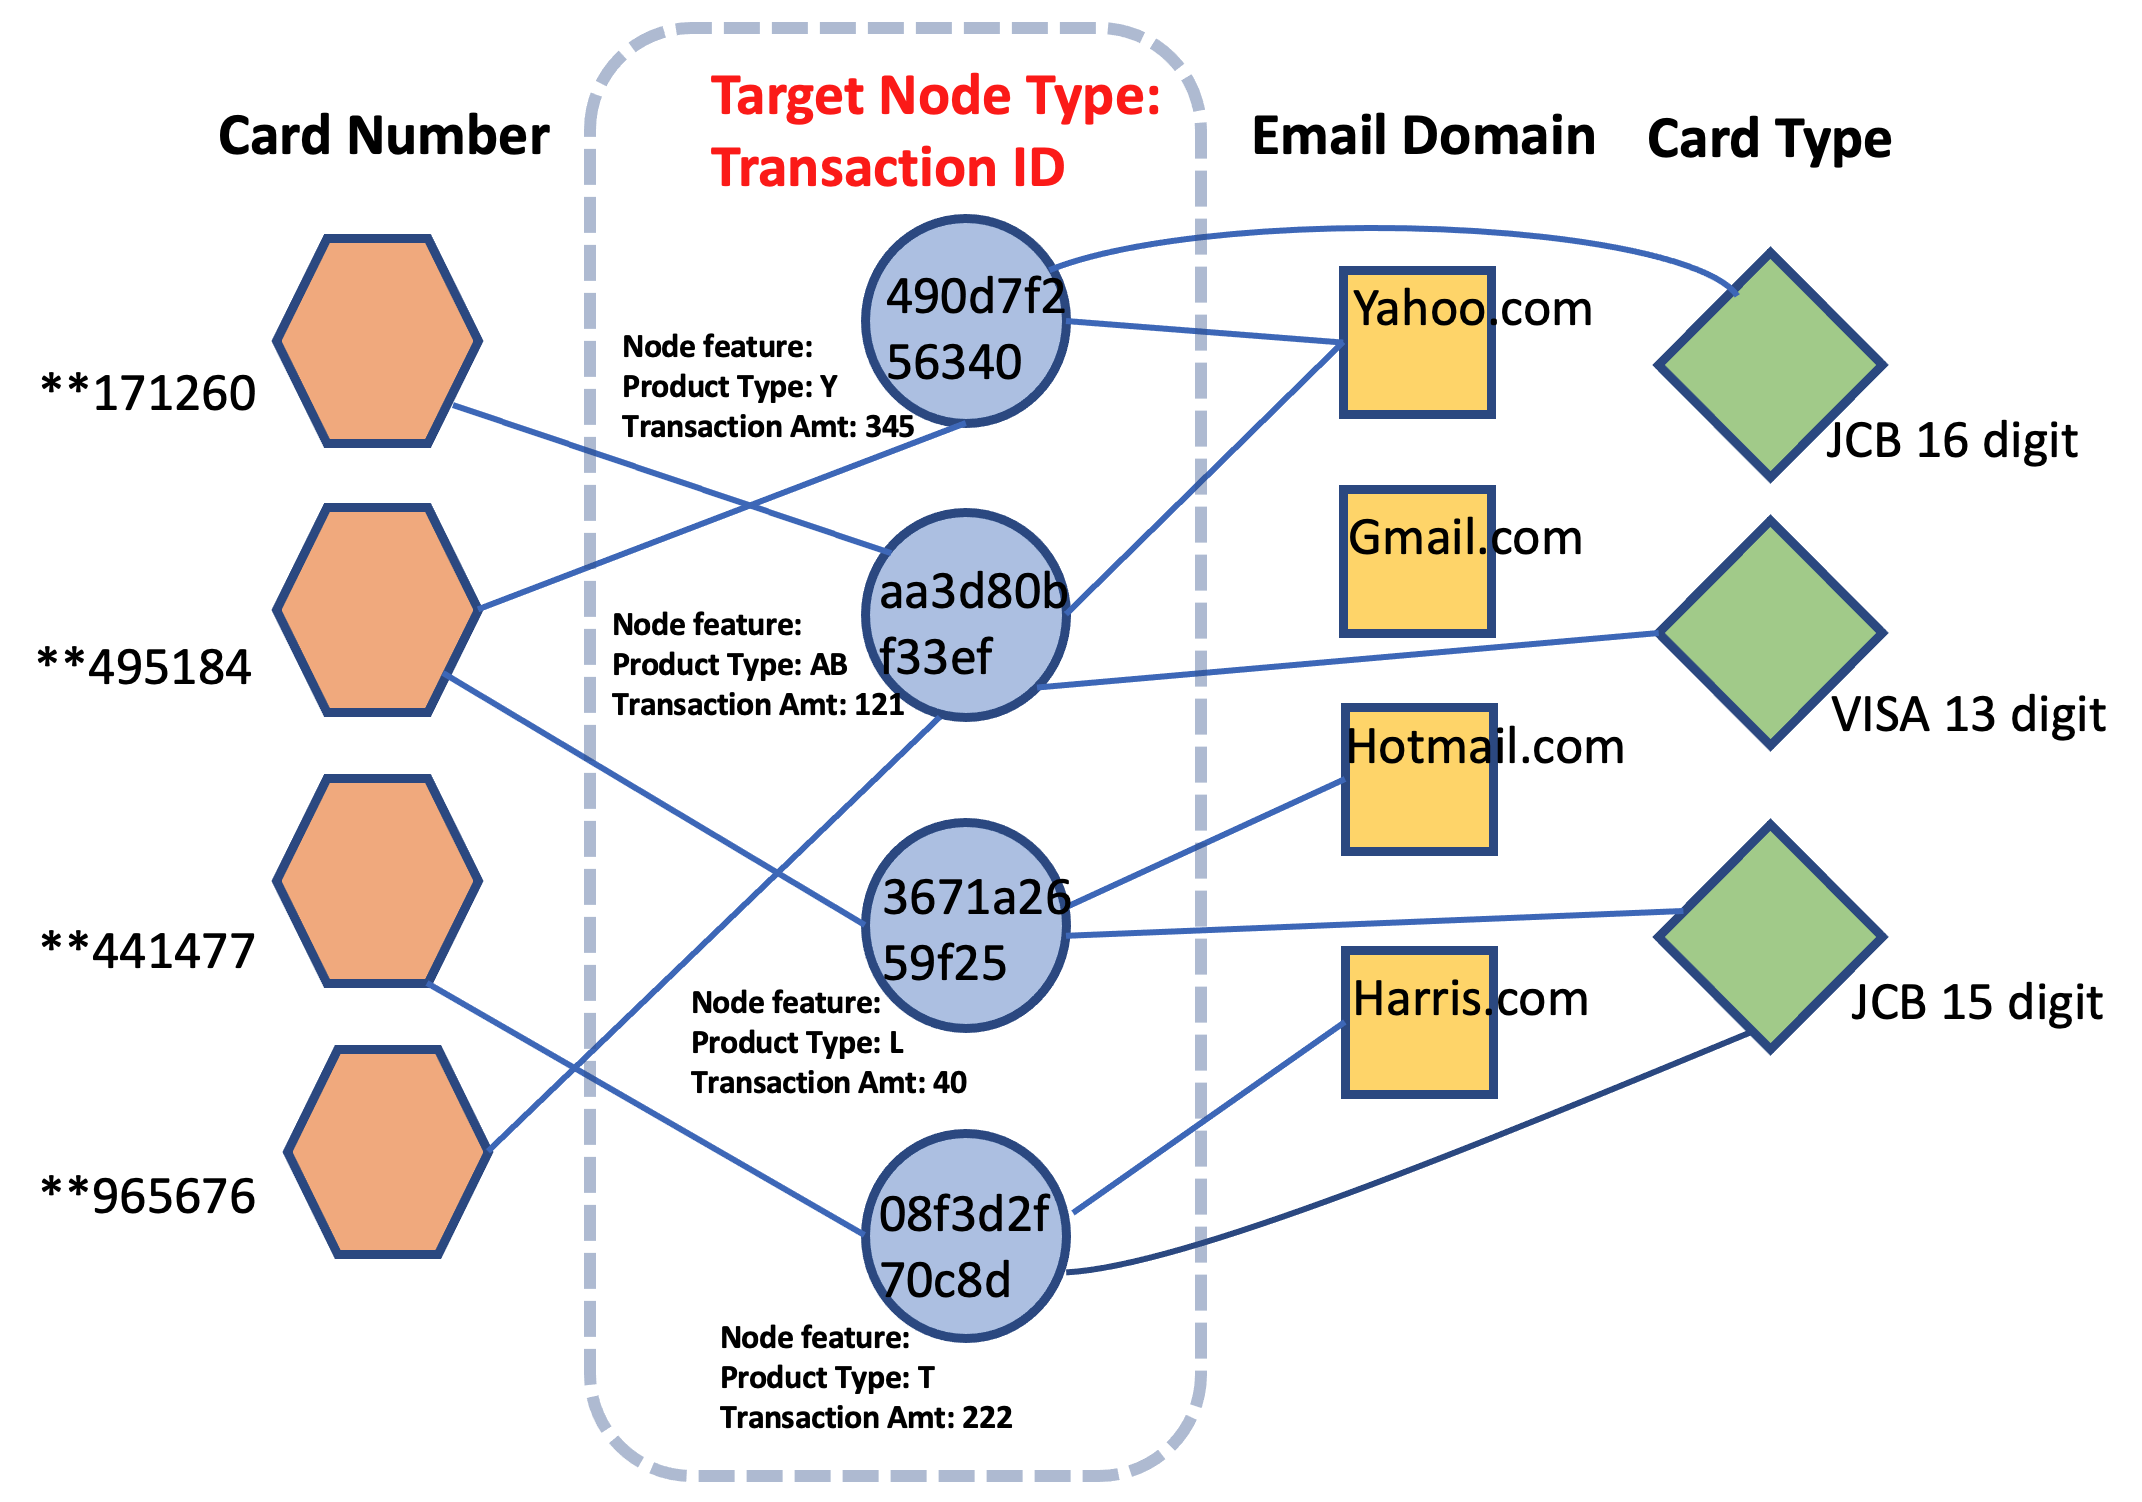

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "illustration-dgl.png", width=500, height=500)

## Data Preprocessing and Feature Engineering

In [10]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import strftime, gmtime

processing_job_name = "{}-processing-job-{}".format(config.solution_prefix,
                                                    strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_count=1,
                                     instance_type='ml.m5.xlarge',
                                     base_job_name=processing_job_name)

sklearn_processor.run(code='data-preprocessing/graph_data_preprocessor.py',
                     inputs=[ProcessingInput(source=input_data,
                                             destination='/opt/ml/processing/input')],
                     outputs=[ProcessingOutput(destination=train_data,
                                               source='/opt/ml/processing/output')],
                     arguments=[
                         '--id-cols', 'card_no,card_type,email_domain',
                         '--cat-cols','ProductCD',
                         '--cat-cols-xgboost', 'card_type,ProductCD'
                     ])

INFO:sagemaker:Creating processing-job with name sagemaker-soln-fdfn-js-m03txa-processin-2023-07-02-22-34-38-178


........................2023-07-02 22:38:35,461 INFO __main__: Shape of transaction data is (140467, 8)
2023-07-02 22:38:35,462 INFO __main__: # Tagged transactions: 140467
2023-07-02 22:38:35,666 INFO __main__: Shape of identity data is (140467, 4)
2023-07-02 22:38:35,666 INFO __main__: Training, validation, and test data fraction are 0.7, 0.2, and 0.10000000000000003, respectively
2023-07-02 22:38:35,673 INFO __main__: Percentage of fraud transactions for train data: 17.928116673107827
2023-07-02 22:38:35,676 INFO __main__: Percentage of fraud transactions for validation data: 17.555349896775112
2023-07-02 22:38:35,677 INFO __main__: Percentage of fraud transactions for test data: 18.288602548586887
2023-07-02 22:38:35,686 INFO __main__: Percentage of fraud transactions for all data: 17.88961108303018
2023-07-02 22:38:35,697 INFO __main__: Wrote validaton data to file: /opt/ml/processing/output/validation.csv
2023-07-02 22:38:35,702 INFO __main__: Wrote test data to file: /opt/ml/pro

### View Results of Data Preprocessing

Once the preprocessing job is complete,  can take a look at the contents of the S3 bucket to see the transformed data.  have a set of bipartite edge lists between transactions and different device id types as well as the features, labels and a set of transactions to validate our graph model performance.

In [ ]:
from os import path
from sagemaker.s3 import S3Downloader
processed_files = S3Downloader.list(train_data)
print("===== Processed Files =====")
print('\n'.join(processed_files))

#download processed data into local directory preprocessed-data
S3Downloader.download(train_data, train_data.split("/")[-1])

## Train a XGBoost Baseline
Before diving into training a graph neural network with DGL, let us firstly train a XGBoost model with HPO as the baseline on the transaction table data. 

In [12]:
from baselines.utils import get_data
import numpy as np

### Read data and upload to S3
The features used for training XGBoost are from **features_xgboost.csv** that are processed in above processing job.
The features include categorical columns **productCD**, **card_type** and numerical column **TransactionAmt**. The categorical features are onehot encoded. Other features (categorical features) such as **IpAddress**, **PhoneNO** contain too many categories (~40,000) and thus are not suitable to be used as training features for XGBoost.

In [13]:
train_data_df, valid_data_df, test_data_df = get_data()

Let's check the first 5 observations of the train data frame.

In [14]:
train_data_df.head(5)

,isFraud,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
TransactionID,,,,,,,,,,,,,,,,,
9c90c7e2-2600-4628-a868-179287eee169,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3.078457
02951e68-f8ff-4f00-b515-5df8bcb0edcb,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.611723
17071ccd-3c3d-476a-a3cd-b73638a803d4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3.041787
5288f832-6673-473a-80f6-fdb98dd99278,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.347915
e37a6dd1-182e-4b87-8b8e-7dd9bf78cea0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3.378943


Save the training and validation data into local directory and then upload them to s3 bucket for training.

In [15]:
!mkdir -p xgboost_input
train_data_df.to_csv("xgboost_input/train_xgb.csv", header=False, index=False)
valid_data_df.to_csv("xgboost_input/validation_xgb.csv", header=False, index=False)

In [ ]:
import os
import sagemaker
from sagemaker.s3 import S3Uploader

from sagemaker_graph_fraud_detection import config

role = config.role

session = sagemaker.Session()
bucket = config.solution_bucket
prefix = 'xgboost-fraud-detection'

s3_train_data = S3Uploader.upload('xgboost_input/train_xgb.csv', 's3://{}/{}/{}'.format(bucket, prefix,'train'))
print('Uploaded training data location: {}'.format(s3_train_data))

s3_validation_data = S3Uploader.upload('xgboost_input/validation_xgb.csv', 's3://{}/{}/{}'.format(bucket, prefix,'validation'))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

### Train SageMaker XGBoost Estimator with HPO

In [ ]:
import boto3
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri

container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")
display(container)

In [18]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

### Train SageMaker XGBoost Estimator with HPO

In [19]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

train_y = train_data_df.values[:,0]
scale_pos_weight = (len(train_y) - sum(train_y))/sum(train_y)  # as this is unbalanced dataset, we need give more weight to the minority class example.

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1, 
    instance_type='ml.m5.xlarge',#'ml.g4dn.xlarge',
    output_path=output_location,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=1000,
    early_stopping_rounds=10,
    silent=0,
    scale_pos_weight=scale_pos_weight,
)

In [20]:
# Define the hyper-parameters search ranges.
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "gamma": ContinuousParameter(0, 0.6),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
    "subsample": ContinuousParameter(0.2, 1),
}

In [21]:
objective_metric_name = "validation:auc"
objective_type = "Maximize"

In [22]:
tuning_job_name = sagemaker_config["SolutionPrefix"]
print(
    f"You can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with {tuning_job_name} to monitor HPO tuning status and details.\n"
    f"Note. You will be unable to successfully run the following cells until the tuning job completes. This step may take around 15 min."
)

tuner = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=30, 
    max_parallel_jobs=10, 
    objective_type=objective_type,
    base_tuning_job_name = tuning_job_name,
)

tuner.fit({'train': s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-soln-fdfn--230702-2239


You can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with sagemaker-soln-fdfn-js-m03txa to monitor HPO tuning status and details.
Note. You will be unable to successfully run the following cells until the tuning job completes. This step may take around 15 min.
..........................................................!


Check the Status of HPO tuning jobs

In [23]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

'Completed'

Retrieve the tuning job name

In [24]:
import boto3
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'sagemaker-soln-fdfn--230702-2239'

In [25]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_maximize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

30 training jobs have completed


In [26]:
import pandas as pd

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=False)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 30
{'lowest': 0.7721220254898071, 'highest': 0.7771739959716797}


/tmp/ipykernel_66/327150094.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName


,alpha,eta,gamma,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
15,0.593917,0.470140,0.343040,2.0,2.282635,0.463246,sagemaker-soln-fdfn--230702-2239-015-6f7000a4,Completed,0.777174,2023-07-02 22:42:43+00:00,2023-07-02 22:43:10+00:00,27.0
5,0.559905,0.970886,0.350272,2.0,2.299925,0.913092,sagemaker-soln-fdfn--230702-2239-025-25cbb142,Completed,0.776371,2023-07-02 22:43:32+00:00,2023-07-02 22:44:00+00:00,28.0
27,1.621805,0.490607,0.067371,9.0,1.206925,0.611576,sagemaker-soln-fdfn--230702-2239-003-4dd9171c,Completed,0.775688,2023-07-02 22:40:54+00:00,2023-07-02 22:42:11+00:00,77.0
2,0.856939,0.889513,0.361369,2.0,1.036748,0.530123,sagemaker-soln-fdfn--230702-2239-028-1392486a,Completed,0.775646,2023-07-02 22:43:47+00:00,2023-07-02 22:44:14+00:00,27.0
0,0.903268,0.077519,0.441603,4.0,7.130877,0.409292,sagemaker-soln-fdfn--230702-2239-030-43d0a8a9,Completed,0.775314,2023-07-02 22:44:00+00:00,2023-07-02 22:44:27+00:00,27.0
23,0.575673,0.551680,0.556517,2.0,3.305080,0.415456,sagemaker-soln-fdfn--230702-2239-007-b6fe6a2f,Completed,0.775105,2023-07-02 22:41:01+00:00,2023-07-02 22:42:18+00:00,77.0
17,1.688679,0.473826,0.542866,2.0,1.144187,0.367954,sagemaker-soln-fdfn--230702-2239-013-6b76d9ce,Completed,0.775042,2023-07-02 22:42:38+00:00,2023-07-02 22:43:05+00:00,27.0
8,0.239695,0.508222,0.342690,5.0,5.674963,0.511632,sagemaker-soln-fdfn--230702-2239-022-2cd09de8,Completed,0.775011,2023-07-02 22:43:28+00:00,2023-07-02 22:43:55+00:00,27.0
4,0.632631,0.547989,0.335928,6.0,5.068132,0.473345,sagemaker-soln-fdfn--230702-2239-026-c418d4ee,Completed,0.774757,2023-07-02 22:43:35+00:00,2023-07-02 22:44:01+00:00,26.0
28,1.578876,0.358898,0.239578,6.0,4.030257,0.919852,sagemaker-soln-fdfn--230702-2239-002-79e0d87f,Completed,0.774718,2023-07-02 22:40:52+00:00,2023-07-02 22:42:14+00:00,82.0


### Deploy endpoint of the best tuning job

In [27]:
from sagemaker.serializers import CSVSerializer

print(f"You can go to SageMaker -> Inference -> Endpoints --> an endpoint with name started with {tuning_job_name} to monitor the deployment status.")

predictor_hpo = tuner.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", serializer=CSVSerializer(),
)

You can go to SageMaker -> Inference -> Endpoints --> an endpoint with name started with sagemaker-soln-fdfn--230702-2239 to monitor the deployment status.

2023-07-02 22:43:31 Starting - Found matching resource for reuse
2023-07-02 22:43:31 Downloading - Downloading input data
2023-07-02 22:43:31 Training - Training image download completed. Training in progress.
2023-07-02 22:43:31 Uploading - Uploading generated training model
2023-07-02 22:43:31 Completed - Resource reused by training job: sagemaker-soln-fdfn--230702-2239-025-25cbb142

INFO:sagemaker:Creating model with name: sagemaker-soln-fdfn--2023-07-02-22-44-45-228


INFO:sagemaker:Creating endpoint-config with name sagemaker-soln-fdfn--230702-2239-015-6f7000a4
INFO:sagemaker:Creating endpoint with name sagemaker-soln-fdfn--230702-2239-015-6f7000a4


----!

In [28]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, current_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

hpo_raw_preds = predict(predictor_hpo, test_data_df.values[:, 1:]) # estimated probability for positive class
hpo_preds = np.where(hpo_raw_preds > 0.5, 1, 0) # generate prediction label

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from matplotlib import pyplot as plt

def print_metrics(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    cm = pd.DataFrame(np.array([[true_pos, false_pos], [false_neg, true_neg]]),
                                    columns=["labels positive", "labels negative"],
                                    index=["predicted positive", "predicted negative"])
    
    acc = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)
    precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos/(true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2*(precision*recall)/(precision + recall) if (precision + recall) > 0 else 0
    return [f1, precision, recall, acc]

In [30]:
result_xgboost_with_hpo = print_metrics(test_data_df.values[:,0], hpo_preds)
fpr, tpr, _ = roc_curve(test_data_df.values[:,0], hpo_raw_preds)
roc_auc = auc(fpr, tpr)
result_xgboost_with_hpo.append(roc_auc)
result_xgboost_with_hpo = pd.DataFrame(
    result_xgboost_with_hpo, index=['F1', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC'], 
    columns=['XGBoost_With_HPO']
)

print(result_xgboost_with_hpo)

           XGBoost_With_HPO
F1         0.583797        
Precision  0.514549        
Recall     0.674582        
Accuracy   0.824091        
ROC_AUC    0.767816        


## Train Graph Neural Network using DGL

Graph Neural Networks work by learning representation for nodes or edges of a graph that are well suited for some downstream task. We can model the fraud detection problem as a node classification task, and the goal of the graph neural network would be to learn how to use information from the topology of the sub-graph for each transaction node to transform the node's features to a representation space where the node can be easily classified as fraud or not.

Specifically, we will be using a relational graph convolutional neural network model (R-GCN) on a heterogeneous graph since we have nodes and edges of different types.

### Hyperparameters

To train the graph neural network, we need to define a few hyperparameters that determine properties such as the class of graph neural network models we will be using, the network architecture and the optimizer and optimization parameters. 

Here we're setting only a few of the hyperparameters, to see all the hyperparameters and their default values, see `dgl-fraud-detection/estimator_fns.py`. The parameters set below are:

* **`nodes`** is the name of the file that contains the `node_id`s of the target nodes and the node features.
* **`edges`** is a regular expression that when expanded lists all the filenames for the edgelists
* **`labels`** is the name of the file tha contains the target `node_id`s and their labels
* **`model`** specify which graph neural network to use, this should be set to `r-gcn`

The following hyperparameters can be tuned and adjusted to improve model performance
* **batch-size** is the number nodes that are used to compute a single forward pass of the GNN

* **embedding-size** is the size of the embedding dimension for non target nodes
* **n-neighbors** is the number of neighbours to sample for each target node during graph sampling for mini-batch training
* **n-layers** is the number of GNN layers in the model
* **n-epochs** is the number of training epochs for the model training job
* **optimizer** is the optimization algorithm used for gradient based parameter updates
* **lr** is the learning rate for parameter updates


In [31]:
edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in processed_files if "relation" in file]))
params = {'nodes' : 'features.csv',
          'edges': 'relation*',
          'labels': 'tags.csv',
          'model': 'rgcn',
          'num-gpus': 1,
          'batch-size': 1000,
          'embedding-size': 1024,
          'n-neighbors': 100,
          'n-layers': 2,
          'n-epochs': 10,
          'optimizer': 'adam',
          'lr': 1e-2
        }

print("Graph will be constructed using the following edgelists:\n{}" .format('\n'.join(edges.split(","))))

Graph will be constructed using the following edgelists:
relation_DeviceID_edgelist.csv
relation_IpAddress_edgelist.csv
relation_PhoneNo_edgelist.csv
relation_TransactionID_edgelist.csv
relation_card_no_edgelist.csv
relation_card_type_edgelist.csv
relation_email_domain_edgelist.csv


### Create and Fit SageMaker Estimator

With the hyperparameters defined, we can kick off the training job. We will be using the Deep Graph Library (DGL), with MXNet as the backend deep learning framework, to define and train the graph neural network. Amazon SageMaker makes it do this with the Framework estimators which have the deep learning frameworks already setup. Here, we create a SageMaker MXNet estimator and pass in our model training script, hyperparameters, as well as the number and type of training instances we want.

We can then `fit` the estimator on the the training data location in S3.

In [ ]:
from sagemaker.mxnet import MXNet
from time import strftime, gmtime

estimator = MXNet(
    entry_point='train_dgl_mxnet_entry_point.py',
    source_dir='sagemaker_graph_fraud_detection/dgl_fraud_detection',
    role=role, 
    instance_count=1, 
    instance_type='ml.g4dn.xlarge',
    framework_version="1.6.0",
    py_version='py3',
    hyperparameters=params,
    output_path=train_output,
    code_location=train_output,
    sagemaker_session=sess,
)

training_job_name = "{}-{}".format(config.solution_prefix, strftime("%Y-%m-%d-%H-%M-%S", gmtime()))
print(
    f"You can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with {training_job_name} to monitor training job status and details."
)
estimator.fit({'train': train_data}, job_name=training_job_name)

Once the training is completed, the training instances are automatically stopped and SageMaker stores the trained model and evaluation results (on the test data) to a location in S3.

### Read the prediction output for the test data
Current training process is transductive setting where the predicting columns of test dataset (not including the target column) are used to construct the graph and thus the test data are included in the training process. At the end of training, the predictions on the test dataset are generated and saved in the **train_output** in the s3 bucket.

In [ ]:
test_output_path = os.path.join(train_output, estimator.latest_training_job.job_name, "output")
!mkdir -p output_dgl_job
!aws s3 cp --recursive $test_output_path output_dgl_job

In [34]:
import tarfile
  
# open file
tar = tarfile.open(os.path.join("output_dgl_job", "output.tar.gz"), "r:gz")
tar.extractall("output_dgl_job")
tar.close()

In [35]:
dgl_output = pd.read_csv(os.path.join("output_dgl_job", "preds.csv"))
dgl_raw_preds, dgl_preds = dgl_output['pred_proba'], dgl_output['pred']

result_dgl_no_hpo = print_metrics(test_data_df.iloc[:, 0], dgl_preds)
fpr, tpr, _ = roc_curve(test_data_df.iloc[:, 0], dgl_raw_preds)
roc_auc = auc(fpr, tpr)
result_dgl_no_hpo.append(roc_auc)
result_dgl_no_hpo = pd.DataFrame(
    result_dgl_no_hpo, index=['F1', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC'], 
    columns=['DGL_No_HPO']
)

Combine the results with XGBoost

In [36]:
result_xgboost_dgl = result_xgboost_with_hpo.join(result_dgl_no_hpo)
print(result_xgboost_dgl)

           XGBoost_With_HPO  DGL_No_HPO
F1         0.583797          0.637275  
Precision  0.514549          0.893886  
Recall     0.674582          0.495134  
Accuracy   0.824091          0.896917  
ROC_AUC    0.767816          0.821893  


### Create and Fit SageMaker Estimator with HPO
In this section we fit the SageMaker Estimator using DGL with HPO.

In [37]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# Static hyperparameters we do not tune
hyperparameters = {
    'nodes' : 'features.csv',
    'edges': 'relation*',
    'labels': 'tags.csv',
    'model': 'rgcn',
    'num-gpus': 1,
    'n-layers': 2,
    'optimizer': 'adam',
}

# Dynamic hyperparameters we want to tune and their searching ranges. For demonstartion purpose, we skip the architecture search by skipping tunning the hyperparameters such as 'skip_rnn_num_layers', 'rnn_num_layers', and etc.
hyperparameter_ranges = {
    'batch-size': CategoricalParameter([512, 1024, 2048, 10000]),
    'embedding-size': CategoricalParameter([16, 32, 64, 128, 256, 512]),
    'n-neighbors': IntegerParameter(800, 1200),
    'n-epochs': IntegerParameter(10, 17),
    'lr': ContinuousParameter(0.002, 0.1),
}

In [38]:
objective_metric_name = "Validation F1"
metric_definitions = [{"Name": "Validation F1", "Regex": "Validation F1 (\\S+)"}] #Root Relative Squared Error (RSE): 
objective_type = "Maximize"

In [39]:
from sagemaker.mxnet import MXNet

estimator_tuning = MXNet(
    entry_point='train_dgl_mxnet_entry_point.py',
    source_dir='sagemaker_graph_fraud_detection/dgl_fraud_detection',
    role=role, 
    instance_count=1, 
    instance_type='ml.g4dn.xlarge',
    framework_version="1.6.0",
    py_version='py3',
    hyperparameters=params,
    output_path=train_output,
    code_location=train_output,
    sagemaker_session=sess,
)

In [40]:
import time

tuning_job_name = sagemaker_config["SolutionPrefix"]
print(
    f"You can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with {tuning_job_name} to monitor HPO tuning status and details.\n"
    f"Note. You will be unable to successfully run the following cells until the tuning job completes. This step may take around 2 hour."
)

tuner = HyperparameterTuner(
    estimator_tuning,  # using the estimator defined in previous section
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=30,
    max_parallel_jobs=10,
    objective_type=objective_type,
    base_tuning_job_name = tuning_job_name,
)

start_time = time.time()

tuner.fit({'train': train_data})

hpo_training_job_time_duration = time.time() - start_time

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


You can go to SageMaker -> Training -> Hyperparameter tuning jobs -> a job name started with sagemaker-soln-fdfn-js-m03txa to monitor HPO tuning status and details.
Note. You will be unable to successfully run the following cells until the tuning job completes. This step may take around 2 hour.
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-soln-fdfn--230702-2259


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [41]:
import boto3
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'sagemaker-soln-fdfn--230702-2259'

In [42]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Minimize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

30 training jobs have completed


In [43]:
tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=False)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 30
{'lowest': 0.4731999933719635, 'highest': 0.6290000081062317}


/tmp/ipykernel_66/219735052.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName


,batch-size,embedding-size,lr,n-epochs,n-neighbors,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
17,"""2048""","""512""",0.009362,12.0,874.0,sagemaker-soln-fdfn--230702-2259-013-5a26562e,Completed,0.6290,2023-07-02 23:16:27+00:00,2023-07-02 23:34:08+00:00,1061.0
11,"""2048""","""32""",0.016506,17.0,800.0,sagemaker-soln-fdfn--230702-2259-019-a8a39f9f,Completed,0.5997,2023-07-02 23:26:39+00:00,2023-07-02 23:48:14+00:00,1295.0
21,"""2048""","""256""",0.033318,17.0,1131.0,sagemaker-soln-fdfn--230702-2259-009-e1853487,Completed,0.5912,2023-07-02 23:00:36+00:00,2023-07-02 23:22:12+00:00,1296.0
15,"""10000""","""16""",0.007437,16.0,808.0,sagemaker-soln-fdfn--230702-2259-015-43475d03,Completed,0.5890,2023-07-02 23:20:22+00:00,2023-07-02 23:45:19+00:00,1497.0
14,"""2048""","""256""",0.046375,17.0,1137.0,sagemaker-soln-fdfn--230702-2259-016-26d3a06c,Completed,0.5887,2023-07-02 23:22:36+00:00,2023-07-02 23:43:17+00:00,1241.0
25,"""1024""","""256""",0.085513,13.0,1165.0,sagemaker-soln-fdfn--230702-2259-005-d98448c2,Completed,0.5863,2023-07-02 23:00:37+00:00,2023-07-02 23:22:51+00:00,1334.0
1,"""2048""","""32""",0.007965,11.0,874.0,sagemaker-soln-fdfn--230702-2259-029-cab1b91c,Completed,0.5855,2023-07-02 23:49:11+00:00,2023-07-03 00:01:35+00:00,744.0
9,"""1024""","""16""",0.080176,14.0,846.0,sagemaker-soln-fdfn--230702-2259-021-894eb80a,Completed,0.5847,2023-07-02 23:34:26+00:00,2023-07-02 23:53:17+00:00,1131.0
2,"""2048""","""32""",0.021522,16.0,804.0,sagemaker-soln-fdfn--230702-2259-028-e56ed68c,Completed,0.5695,2023-07-02 23:49:11+00:00,2023-07-03 00:04:35+00:00,924.0
23,"""2048""","""16""",0.073039,13.0,1077.0,sagemaker-soln-fdfn--230702-2259-007-95c0c352,Completed,0.5664,2023-07-02 23:00:32+00:00,2023-07-02 23:17:42+00:00,1030.0


### Read the prediction output for the test dataset from the best tuning job

In [ ]:
import os
df = df[df["TrainingJobStatus"] == "Completed"] # filter out the failed jobs
output_path_best_tuning_job = os.path.join(train_output, df["TrainingJobName"].iloc[0], "output")
print(output_path_best_tuning_job)

In [ ]:
!mkdir -p output_dgl_best_tuning_job
!aws s3 cp --recursive $output_path_best_tuning_job output_dgl_best_tuning_job

In [46]:
import tarfile
  
# open file
tar = tarfile.open(os.path.join("output_dgl_best_tuning_job", "output.tar.gz"), "r:gz")
tar.extractall("output_dgl_best_tuning_job")
tar.close()

In [47]:
dgl_output_hpo = pd.read_csv(os.path.join("output_dgl_best_tuning_job", "preds.csv"))
dgl_hpo_raw_preds, dgl_hpo_preds = dgl_output_hpo['pred_proba'], dgl_output_hpo['pred']

result_dgl_with_hpo = print_metrics(test_data_df.values[:,0], dgl_hpo_preds)
fpr, tpr, _ = roc_curve(test_data_df.values[:,0], dgl_hpo_raw_preds)
roc_auc = auc(fpr, tpr)
result_dgl_with_hpo.append(roc_auc)
result_dgl_with_hpo = pd.DataFrame(
    result_dgl_with_hpo, index=['F1', 'Precision', 'Recall', 'Accuracy', 'ROC_AUC'], 
    columns=['DGL_With_HPO']
)


result_xgboost_dgl_full = result_xgboost_dgl.join(result_dgl_with_hpo)
print(result_xgboost_dgl_full)

           XGBoost_With_HPO  DGL_No_HPO  DGL_With_HPO
F1         0.583797          0.637275    0.670056    
Precision  0.514549          0.893886    0.886044    
Recall     0.674582          0.495134    0.538731    
Accuracy   0.824091          0.896917    0.902969    
ROC_AUC    0.767816          0.821893    0.818905    


## Clean Up


After you are done using this notebook, delete the model artifacts and other resources to avoid any incurring charges.

**Caution**: You need to manually delete resources that you may have created while running the notebook, such as Amazon S3 buckets for model artifacts, training datasets, processing artifacts, and Amazon CloudWatch log groups.


### Delete the Endpoint Created from XGBoost

In [48]:
predictor_hpo.delete_model()
predictor_hpo.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-soln-fdfn--2023-07-02-22-44-45-228
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-soln-fdfn--230702-2239-015-6f7000a4
INFO:sagemaker:Deleting endpoint with name: sagemaker-soln-fdfn--230702-2239-015-6f7000a4
